### Notebook for experimenting/debugging data reduction related stuff and doing initial data analysis

In [1]:
from data_reduction import DataSheet, xlsx_temp_series, xlsx_modulation, df_label_names
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.debugger import Tracer

In [2]:
# Define constants
NUM_SHEETS_MOD = 32
NUM_SHEETS_TEMP = 8

In [3]:
# Create a list of DataSheet objects for the flux bias current/modulation Excel sheet
mod_DataSheets = []
for j in range(NUM_SHEETS_MOD):
    mod_DataSheets.append(DataSheet(xlsx_modulation, 'modulation', sheet_num = j))
    
temp_DataSheets = []
for j in range(NUM_SHEETS_TEMP):
    temp_DataSheets.append(DataSheet(xlsx_temp_series, 'temperature series', sheet_num = j))

In [4]:
# Mean subtract
for sheet in mod_DataSheets:
    sheet.mean_subtract()

for sheet in temp_DataSheets:
    sheet.mean_subtract()

In [5]:
# Combine the three sets for each sheet
for sheet in mod_DataSheets:
    sheet.combine_sets()

for sheet in temp_DataSheets:
    sheet.combine_sets()

In [6]:
# Window Average to down sample
for sheet in mod_DataSheets:
    sheet.combined_set = sheet.window_avg(sheet.combined_set, n=10)

for sheet in temp_DataSheets:
    sheet.combined_set = sheet.window_avg(sheet.combined_set, n=10)

In [7]:
print(len(mod_DataSheets[0].combined_set))

300


In [8]:
mod_no_linear_trend_list = []
for sheet in mod_DataSheets:
    #Tracer()()
    mod_no_linear_trend_list.append(sheet.linear_gnd_trend(sheet.combined_set))
print(len(mod_no_linear_trend_list))

Average slope over superconducting region: 0.012755947263999999
Polyfit slope over superconducting region: 0.012479582952930432
Average slope over superconducting region: 0.0141111808
Polyfit slope over superconducting region: 0.014066812251038906
Average slope over superconducting region: 0.0021615271220055713
Polyfit slope over superconducting region: 0.0017499940223050688
Average slope over superconducting region: 0.002502247831578947
Polyfit slope over superconducting region: 0.001781366387181104
Average slope over superconducting region: 0.0021148598055776885
Polyfit slope over superconducting region: 0.0016854419892522194
Average slope over superconducting region: 0.002269817018181819
Polyfit slope over superconducting region: 0.0016957074141029527
Average slope over superconducting region: 0.0018101804589254762
Polyfit slope over superconducting region: 0.001697602244918641
Average slope over superconducting region: 0.0025007999999999996
Polyfit slope over superconducting region

Sheet index = 0


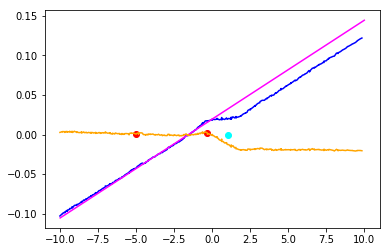

Sheet index = 1


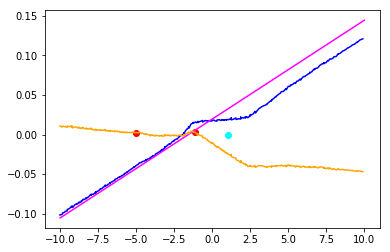

Sheet index = 2


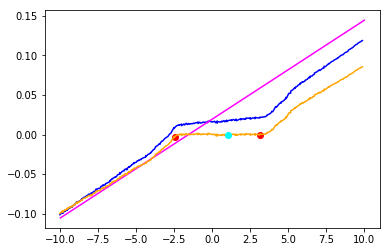

Sheet index = 3


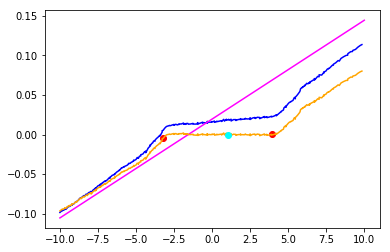

Sheet index = 4


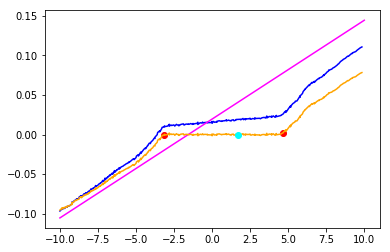

Sheet index = 5


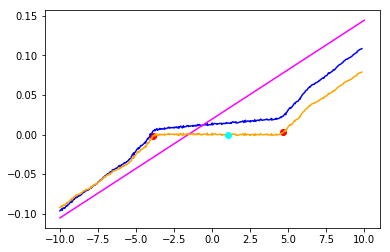

Sheet index = 6


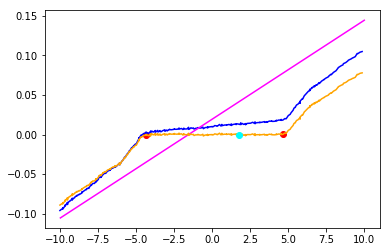

Sheet index = 7


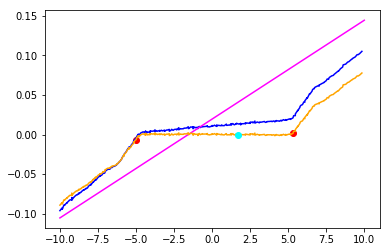

Sheet index = 8


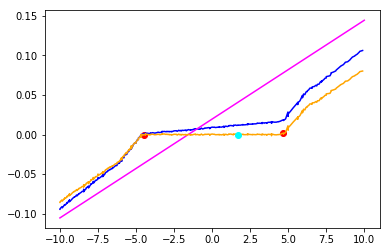

Sheet index = 9


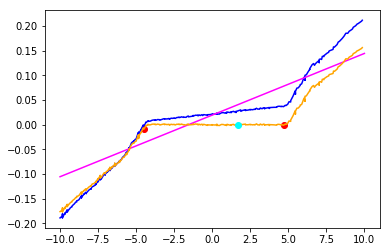

Sheet index = 10


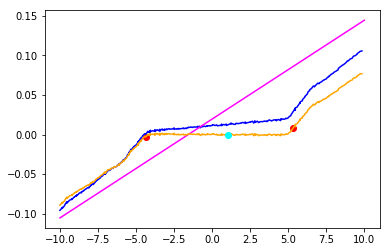

Sheet index = 11


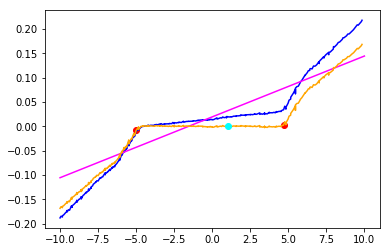

Sheet index = 12


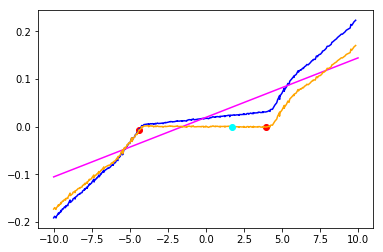

Sheet index = 13


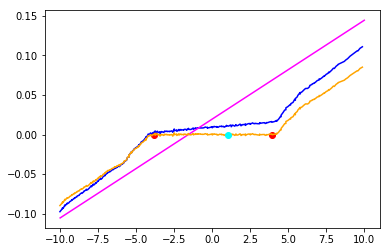

Sheet index = 14


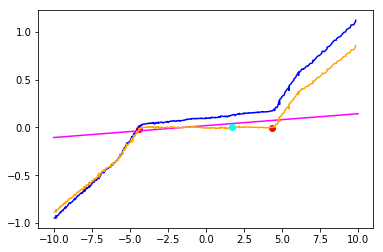

Sheet index = 15


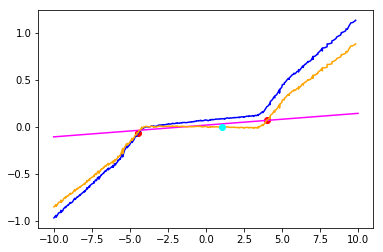

Sheet index = 16


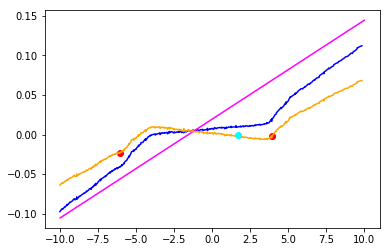

Sheet index = 17


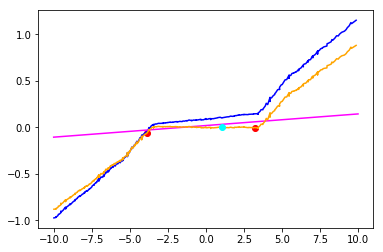

Sheet index = 18


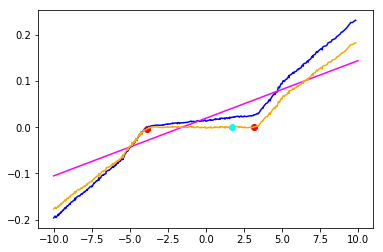

Sheet index = 19


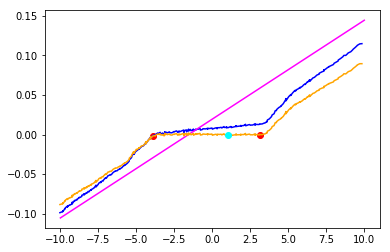

Sheet index = 20


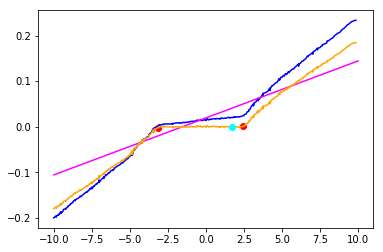

Sheet index = 21


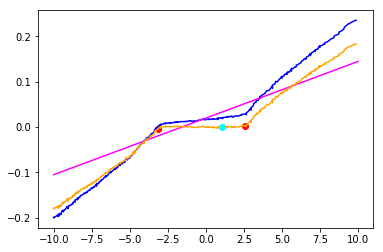

Sheet index = 22


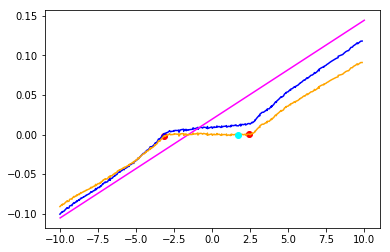

Sheet index = 23


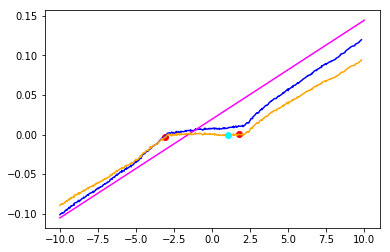

Sheet index = 24


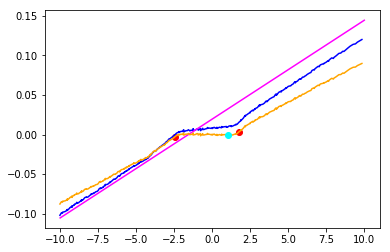

Sheet index = 25


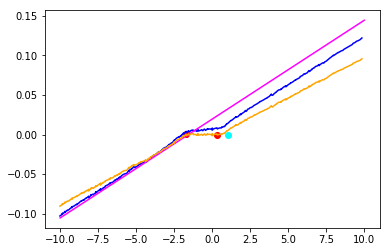

Sheet index = 26


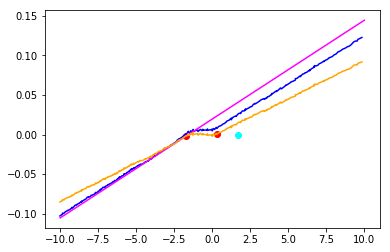

Sheet index = 27


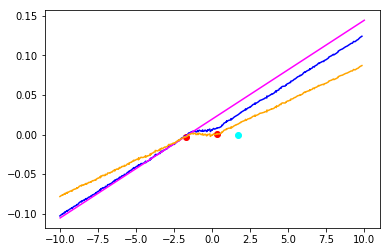

Sheet index = 28


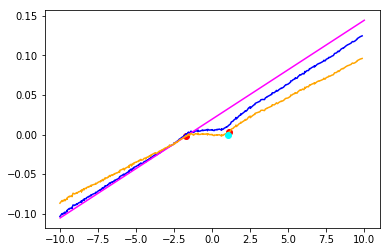

Sheet index = 29


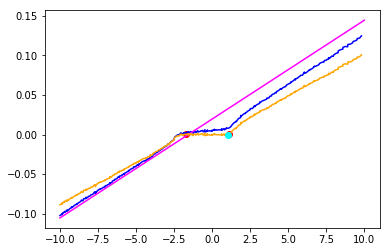

Sheet index = 30


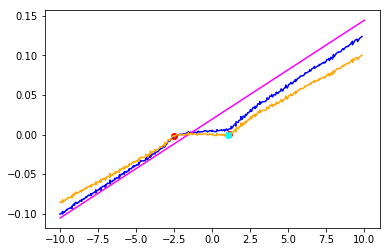

Sheet index = 31


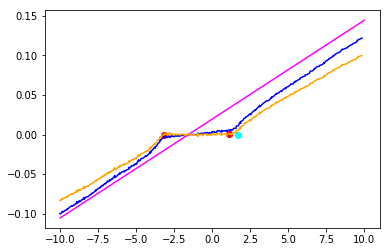

In [10]:
for sheet_idx in range(len(mod_no_linear_trend_list)):
    print('Sheet index = {}'.format(sheet_idx))
    chan_1_no_lin, chan_2_no_lin = zip(*mod_no_linear_trend_list[sheet_idx][0])
    chan_1, chan_2 = zip(*mod_DataSheets[sheet_idx].combined_set)

    # Plot the original data
    plt.plot(chan_1, chan_2, color='blue')

    # Plot the linear fit to the superconducting region
    x = np.linspace(-10, 10, 300)
    m = mod_no_linear_trend_list[0][1]
    b = mod_no_linear_trend_list[0][2]
    plt.plot(x, m*x + b, color='magenta')

    # Plot the 'kink' locations where we've defined the superconducting region to be
    loc_1 = mod_no_linear_trend_list[sheet_idx][3]
    loc_2 = mod_no_linear_trend_list[sheet_idx][4]
    plt.scatter(chan_1_no_lin[loc_1], chan_2_no_lin[loc_1], color='red')
    plt.scatter(chan_1_no_lin[loc_2], chan_2_no_lin[loc_2], color='red')

    # Plot the 'idx_zero' point. Where the script thinks the superconducting region is
    idx_zero = mod_no_linear_trend_list[sheet_idx][6]
    zero_x = np.linspace(-10, 10, 30)
    plt.scatter(zero_x[idx_zero], 0, color='cyan', zorder=100)

    # Plot the linear trend subtracted data
    plt.plot(chan_1_no_lin, chan_2_no_lin, color='orange')
    
    plt.show()

In [20]:
def heaviside(x1):
    return 0.5*(np.sign(x1) + 1)

In [30]:
def super_model(x, m_n, m_s, I_c_left, I_c_right):
    return m_n*(x-I_c_left)*(1 - heaviside(x - I_c_left))+m_n*(x-I_c_right)*heaviside(x - I_c_right) + m_s*x*(heaviside(x - I_c_left) - heaviside(x - I_c_right))

IndexError: index 16 is out of bounds for axis 0 with size 15

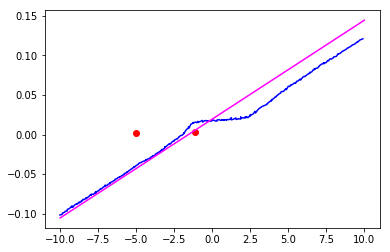

In [28]:
sheet_idx = 1
chan_1_no_lin, chan_2_no_lin = zip(*mod_no_linear_trend_list[sheet_idx][0])
chan_1, chan_2 = zip(*mod_DataSheets[sheet_idx].combined_set)

# Plot the original data
plt.plot(chan_1, chan_2, color='blue')

# Plot the linear fit to the superconducting region
x = np.linspace(-10, 10, 300)
m = mod_no_linear_trend_list[0][1]
b = mod_no_linear_trend_list[0][2]
plt.plot(x, m*x + b, color='magenta')

# Plot the 'kink' locations where we've defined the superconducting region to be
loc_1 = mod_no_linear_trend_list[sheet_idx][3]
loc_2 = mod_no_linear_trend_list[sheet_idx][4]
plt.scatter(chan_1_no_lin[loc_1], chan_2_no_lin[loc_1], color='red')
plt.scatter(chan_1_no_lin[loc_2], chan_2_no_lin[loc_2], color='red')

# Plot the 'idx_zero' point. Where the script thinks the superconducting region is
idx_zero = mod_no_linear_trend_list[sheet_idx][6]
zero_x = np.linspace(-10, 10, 15)
plt.scatter(zero_x[idx_zero], 0, color='cyan', zorder=100)

# Plot the linear trend subtracted data
plt.plot(chan_1_no_lin, chan_2_no_lin, color='orange')

plt.show()

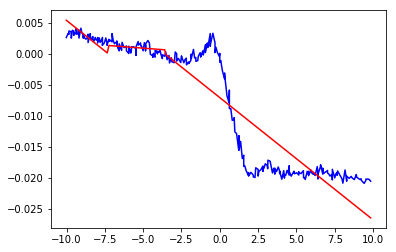

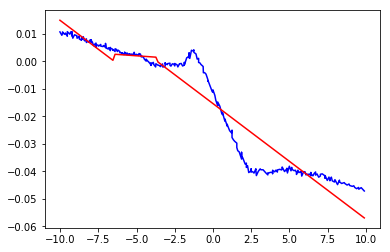

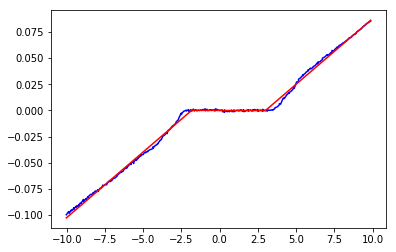

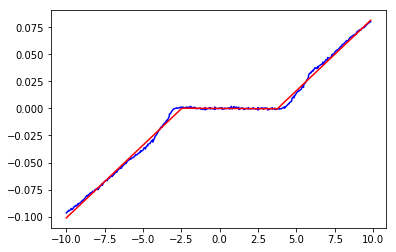

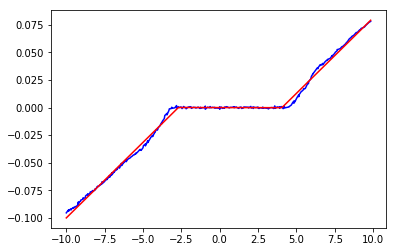

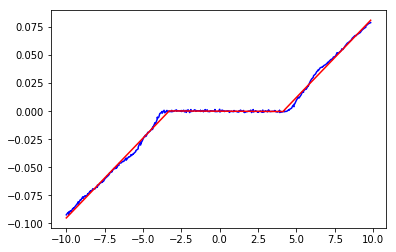

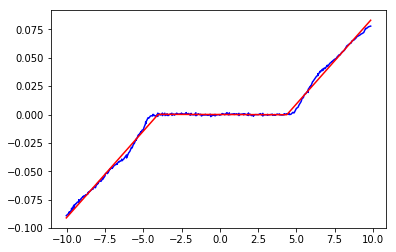

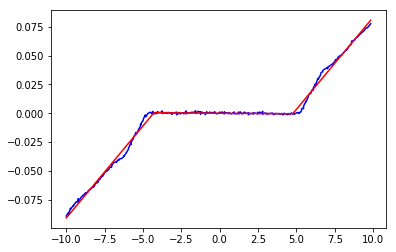

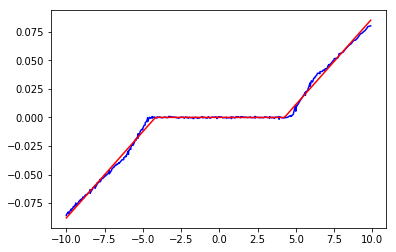

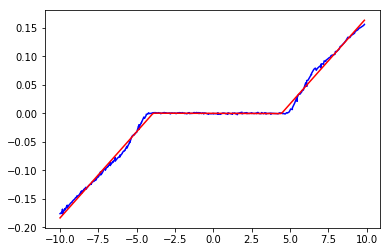

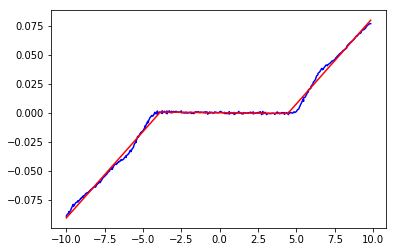

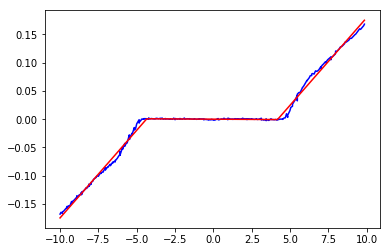

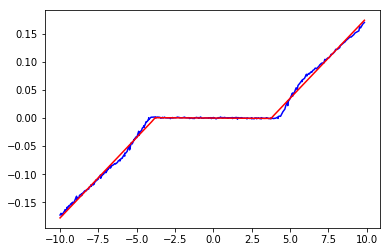

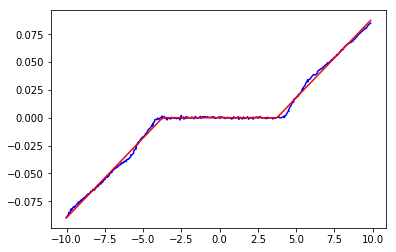

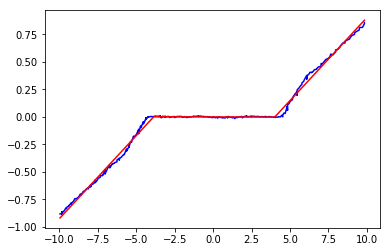

/Users/josephmurphy/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


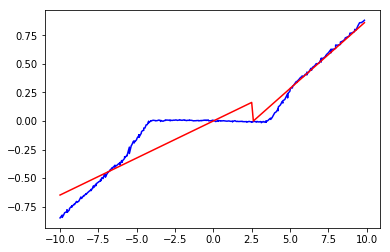

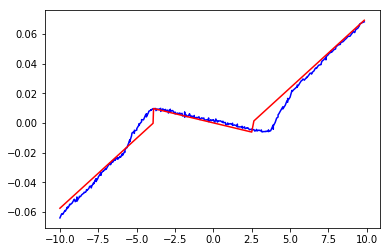

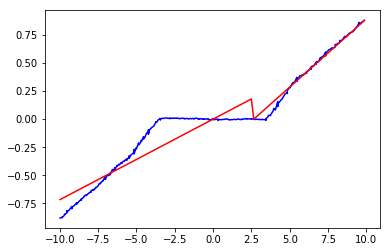

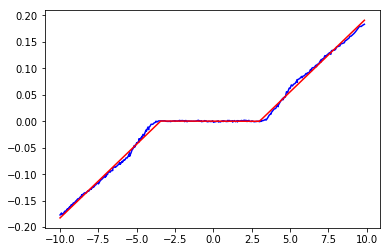

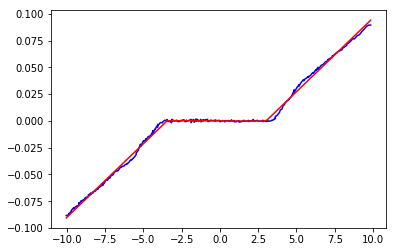

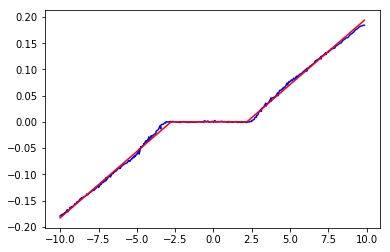

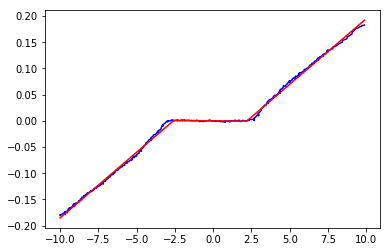

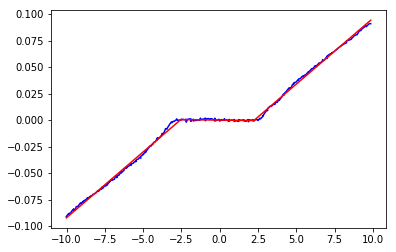

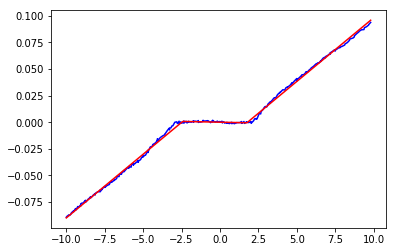

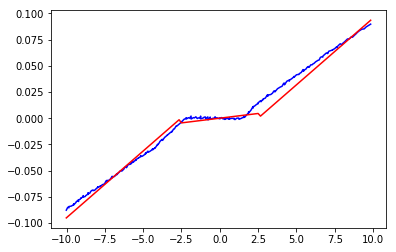

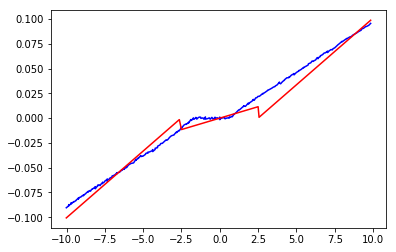

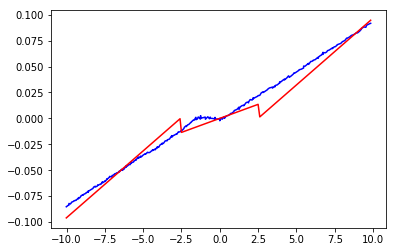

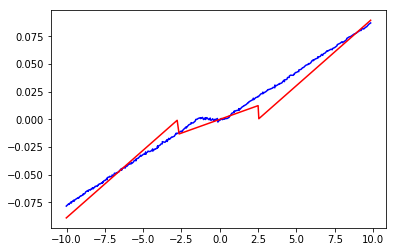

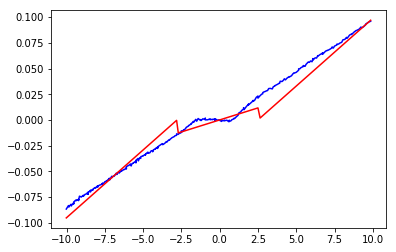

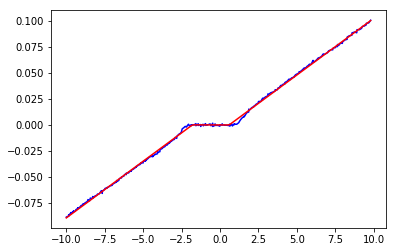

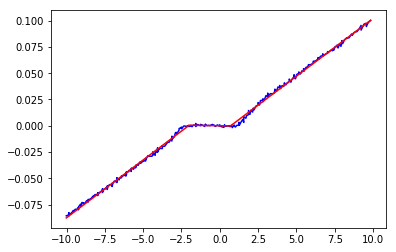

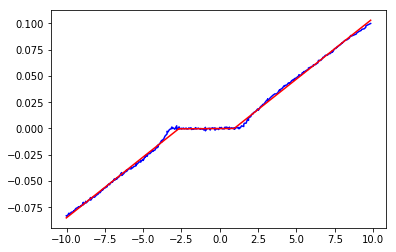

In [33]:
curve_fits = []
for sheet_idx in range(len(mod_no_linear_trend_list)):
    
    chan_1, chan_2 = zip(*mod_no_linear_trend_list[sheet_idx][0])
    #Tracer()()
    
    popt, pcov = curve_fit(super_model, chan_1, chan_2, p0=[0.01, 0.005, -2.0, 2.5])
    chan_1 = np.asarray(chan_1)
    y = super_model(chan_1, popt[0], popt[1], popt[2], popt[3])
    
    plt.plot(chan_1, y, color='red', label='fit', zorder=2)
    plt.plot(chan_1, chan_2, color='blue', label='data', zorder=0)
    plt.show()
    
    y = np.asarray(y)
    chan_2 = np.asarray(chan_2)
    
    fit_tuple = (chan_1, chan_2, popt, pcov)
    curve_fits.append(fit_tuple)

In [56]:
for curve_fit in curve_fits

[array([  1.07834694e-02,  -4.76720075e-04,  -7.77064489e-01,
         2.14874150e+00])]
